## FULLY CONNECTED EDGES

In [46]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout, train_and_evaluate
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import jax.numpy as jnp
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state

In [48]:
import ml_collections

config_full = ml_collections.ConfigDict()

# Data params. 
config_full.n_samples=5000
config_full.input_steps=1
config_full.output_delay=0 # predict 0 hours into the future
config_full.output_steps=4
config_full.timestep_duration= 3
config_full.sample_buffer=-1 * (config_full.input_steps + config_full.output_delay + config_full.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
config_full.time_resolution=120
config_full.init_buffer_samples=0
config_full.train_pct=0.7
config_full.val_pct=0.2
config_full.test_pct=0.1
config_full.K=36
config_full.F=8
config_full.c=10
config_full.b=10
config_full.h=1
config_full.seed=42
config_full.normalize=True
config_full.fully_connected_edges=True

# Optimizer.
config_full.optimizer = 'adam'
config_full.learning_rate = 1e-3

# Training hyperparameters.
# config_full.batch_size = 3
config_full.epochs = 1
config_full.log_every_epochs = 1
config_full.eval_every_epochs = 1
config_full.checkpoint_every_epochs = 1
config_full.max_checkpts_to_keep = None # None means keep all checkpoints

# GNN hyperparameters.
config_full.model = 'MLPGraphNetwork'
config_full.n_blocks = 1
config_full.activation = 'relu'
config_full.dropout_rate = 0.1
config_full.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config_full.layer_norm = False # TODO perhaps we want to turn on later
config_full.edge_features = (4, 8) # the last feature size will be the number of features that the graph predicts
config_full.node_features = (32, 2)
config_full.global_features = None
config_full.share_params = False

In [49]:
import ml_collections

config_neighbor = ml_collections.ConfigDict()

# Data params. 
config_neighbor.n_samples=5000
config_neighbor.input_steps=1
config_neighbor.output_delay=0 # predict 0 hours into the future
config_neighbor.output_steps=4
config_neighbor.timestep_duration=3
config_neighbor.sample_buffer=-1 * (config_neighbor.input_steps + config_neighbor.output_delay + config_neighbor.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
config_neighbor.time_resolution=120
config_neighbor.init_buffer_samples=0
config_neighbor.train_pct=0.7
config_neighbor.val_pct=0.2
config_neighbor.test_pct=0.1
config_neighbor.K=36
config_neighbor.F=8
config_neighbor.c=10
config_neighbor.b=10
config_neighbor.h=1
config_neighbor.seed=42
config_neighbor.normalize=True
config_neighbor.fully_connected_edges=False

# Optimizer.
config_neighbor.optimizer = 'adam'
config_neighbor.learning_rate = 1e-3

# Training hyperparameters.
config_neighbor.epochs = 1
config_neighbor.log_every_epochs = 1
config_neighbor.eval_every_epochs = 1
config_neighbor.checkpoint_every_epochs = 1
config_neighbor.max_checkpts_to_keep = None # None means keep all checkpoints

# GNN hyperparameters.
config_neighbor.model = 'MLPGraphNetwork'
config_neighbor.n_blocks = 1
config_neighbor.activation = 'relu'
config_neighbor.dropout_rate = 0.1
config_neighbor.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config_neighbor.layer_norm = False # TODO perhaps we want to turn on later
config_neighbor.edge_features = (4, 8) # the last feature size will be the number of features that the graph predicts
config_neighbor.node_features = (32, 2)
config_neighbor.global_features = None
config_neighbor.share_params = False

In [50]:
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts

In [51]:
import ml_collections

config_none = ml_collections.ConfigDict()

# Data params. 
config_none.n_samples=5000
config_none.input_steps=1
config_none.output_delay=0 # predict 0 hours into the future
config_none.output_steps=4
config_none.timestep_duration=3
config_none.sample_buffer=-1 * (config_none.input_steps + config_none.output_delay + config_none.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
config_none.time_resolution=120
config_none.init_buffer_samples=0
config_none.train_pct=0.7
config_none.val_pct=0.2
config_none.test_pct=0.1
config_none.K=36
config_none.F=8
config_none.c=10
config_none.b=10
config_none.h=1
config_none.seed=42
config_none.normalize=True
config_none.fully_connected_edges=None

# Optimizer.
config_none.optimizer = 'adam'
config_none.learning_rate = 1e-3

# Training hyperparameters.
config_none.epochs = 1
config_none.log_every_epochs = 1
config_none.eval_every_epochs = 1
config_none.checkpoint_every_epochs = 1
config_none.max_checkpts_to_keep = None # None means keep all checkpoints

# GNN hyperparameters.
config_none.model = 'MLPGraphNetwork'
config_none.n_blocks = 1
config_none.activation = 'relu'
config_none.dropout_rate = 0.1
config_none.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config_none.layer_norm = False # TODO perhaps we want to turn on later
config_none.edge_features = (4, 8) # the last feature size will be the number of features that the graph predicts
config_none.node_features = (32, 2)
config_none.global_features = None
config_none.share_params = False

In [52]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

all of the configs will be using the same dataset, but they will be structured differently based on their edges.

lets look at the lorenz data:

In [53]:
# from utils.lorenz import run_download_lorenz96_2coupled

# run_download_lorenz96_2coupled(
#         fname="data/edges_comparison4", 
#         K=config_full.K,
#         F=config_full.F,
#         c=config_full.c,
#         b=config_full.b,
#         h=config_full.h,
#         n_steps=5000,
#         resolution=config_full.time_resolution,
#         seed=config_full.seed)

In [54]:
# from utils.lorenz import load_lorenz96_2coupled

# t, X = load_lorenz96_2coupled(fname="data/edges_comparison4.npz")
# print(X.shape)
#X

array([[ 0.32578327, -4.28916683, -1.30211818, ...,  0.06031246,
         0.0404452 ,  0.07710581],
       [ 0.01472991, -4.19382678, -1.19932259, ...,  0.05812989,
         0.05479824,  0.08163783],
       [-0.28904825, -4.08045488, -1.1083563 , ...,  0.05593019,
         0.06715246,  0.10130994],
       ...,
       [ 1.58230119,  6.47905682, -2.96733042, ..., -0.25601154,
        -0.1108081 , -0.50972069],
       [ 1.5755851 ,  6.47654575, -2.82643922, ..., -0.23281627,
        -0.09363638, -0.47185909],
       [ 1.56860025,  6.47529936, -2.67791153, ..., -0.20492281,
        -0.08496027, -0.42064696]])

In [55]:
# from utils.lorenz96_plotter import plot_Lorenz96

# plot_Lorenz96(True, False, X, t, 8, 36, config_full.n_samples, config_full.time_resolution)


In [56]:
configs = [config_full, config_neighbor, config_none]
all_datasets = [None, None, None]
i = 0
for config in configs:
    all_datasets[i] = get_lorenz_graph_tuples(
        n_samples=config.n_samples,
        input_steps=config.input_steps,
        output_delay=config.output_delay,
        output_steps=config.output_steps,
        timestep_duration=config.timestep_duration,
        sample_buffer=config.sample_buffer,
        time_resolution=config.time_resolution,
        init_buffer_samples=config.init_buffer_samples,
        train_pct=config.train_pct,
        val_pct=config.val_pct,
        test_pct=config.test_pct,
        K=config.K,
        F=config.F,
        c=config.c,
        b=config.b,
        h=config.h,
        seed=config.seed,
        normalize=config.normalize,
        fully_connected_edges=config.fully_connected_edges)
    i += 1

INFO:root:starting integration


lets check what each graph's edges looks like:

In [57]:
print("Fully Connected Edges:")
test_dataset = all_datasets[0]['test']
test_inputs = test_dataset['inputs']

sample_input_window = test_inputs[0]
sample_graph0 = sample_input_window[0]
print(sample_graph0.edges.shape)
print(sample_graph0.n_edge)
print(sample_graph0)

Fully Connected Edges:
(1296, 1)
[1296]
GraphsTuple(nodes=array([[ 2.4980361 ,  1.261173  ],
       [ 0.8364257 , -0.03748244],
       [-0.37706897, -0.7716691 ],
       [ 0.04991832,  0.30964023],
       [ 0.2884326 ,  0.17659444],
       [ 1.3304703 ,  0.56687295],
       [ 0.47273913,  1.6019795 ],
       [-0.90096265,  1.1067183 ],
       [ 0.5566969 ,  0.24481875],
       [ 1.0551528 , -0.45548928],
       [ 0.37715742, -0.46151522],
       [ 1.1335601 ,  2.1460512 ],
       [ 0.40326738, -0.48951563],
       [-2.2083533 , -1.4724789 ],
       [ 0.11409499,  0.6450212 ],
       [ 0.39142624, -0.17412592],
       [ 1.7153398 , -0.30499423],
       [ 0.5067895 ,  0.51544774],
       [-1.270041  ,  0.98631   ],
       [ 0.83954215,  0.39104113],
       [-0.01212345, -0.47936663],
       [-1.1658683 , -1.295399  ],
       [-0.38850662, -0.7629271 ],
       [ 0.92472064,  0.7685842 ],
       [ 1.1682551 ,  0.78615457],
       [-0.9713449 , -0.8574531 ],
       [ 1.0889972 ,  0.562568  

In [58]:
print("Neighbor-Connected Edges:")
test_dataset = all_datasets[1]['test']
test_inputs = test_dataset['inputs']

sample_input_window = test_inputs[0]
sample_graph1 = sample_input_window[0]
print(sample_graph1.edges.shape)
print(sample_graph1.n_edge)

Neighbor-Connected Edges:
(180, 1)
[180]


In [59]:
print("Neighbor-Connected Edges:")
test_dataset = all_datasets[2]['test']
test_inputs = test_dataset['inputs']

sample_input_window = test_inputs[0]
sample_graph2 = sample_input_window[0]
print(sample_graph2.edges.shape)
print(sample_graph2.senders.shape)
print(sample_graph2.n_edge)

Neighbor-Connected Edges:
(36, 1)
(36,)
[36]


Great! As we can see, we have 1296 (K * K), 180 (K * 5), and 0 edges. let's train each of these

In [60]:
# set up logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

modified the training function to keep track of each epoch's loss for plotting. lets see if we log it accurately:

In [61]:
workdirs = ["tests/outputs/fully4", "tests/outputs/neighbors4", "tests/outputs/none4"]

states = [None, None, None]
trained_metrics = [None, None, None]
eval_metrics = [None, None, None]
all_epoch_losses = [None, None, None]

In [62]:
_, _, eval_metric_0, epoch_losses_0 = train_and_evaluate_with_data(
        config=configs[0], workdir=workdirs[0], datasets=all_datasets[0])
eval_metrics[0] = eval_metric_0
all_epoch_losses[0] = epoch_losses_0

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 1, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 1, 'eval_every_epochs': 1, 'fully_connected_edges': True, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+---

In [63]:
_, _, eval_metric_1, epoch_losses_1 = train_and_evaluate_with_data(
        config=configs[1], workdir=workdirs[1], datasets=all_datasets[1])
eval_metrics[1] = eval_metric_1
all_epoch_losses[1] = epoch_losses_1

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 1, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 1, 'eval_every_epochs': 1, 'fully_connected_edges': False, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+--

In [64]:
_, _, eval_metric_2, epoch_losses_2 = train_and_evaluate_with_data(
        config=configs[2], workdir=workdirs[2], datasets=all_datasets[2])
eval_metrics[2] = eval_metric_2
all_epoch_losses[2] = epoch_losses_2

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'relu', 'b': 10, 'c': 10, 'checkpoint_every_epochs': 1, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 1, 'eval_every_epochs': 1, 'fully_connected_edges': None, 'global_features': None, 'h': 1, 'init_buffer_samples': 0, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'max_checkpts_to_keep': None, 'model': 'MLPGraphNetwork', 'n_blocks': 1, 'n_samples': 5000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+---

INFO:root:Initializing network.


Checkpoint directory: tests/outputs/fully4/checkpoints


INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (4,)     | 4    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 4)   | 24   | -0.0819  | 0.36  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (4, 8)   | 32   | -0.0639  | 0.439 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+-------+
Total: 774
INFO:absl:Checkpoi

Checkpoint directory: tests/outputs/neighbors4/checkpoints


INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (4,)     | 4    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 4)   | 24   | -0.0819  | 0.36  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (4, 8)   | 32   | -0.0639  | 0.439 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+-------+
Total: 774
INFO:absl:Checkpoi

Checkpoint directory: tests/outputs/none4/checkpoints


INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   |
+----------------------------------------+----------+------+----------+-------+
| params/MLPBlock_0/MLP_0/Dense_0/bias   | (4,)     | 4    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_0/kernel | (6, 4)   | 24   | -0.0819  | 0.36  |
| params/MLPBlock_0/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_0/Dense_1/kernel | (4, 8)   | 32   | -0.0639  | 0.439 |
| params/MLPBlock_0/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.00843 | 0.219 |
| params/MLPBlock_0/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0      | 0.0   |
| params/MLPBlock_0/MLP_1/Dense_1/kernel | (32, 2)  | 64   | -0.00627 | 0.195 |
+----------------------------------------+----------+------+----------+-------+
Total: 774
INFO:absl:Checkpoi

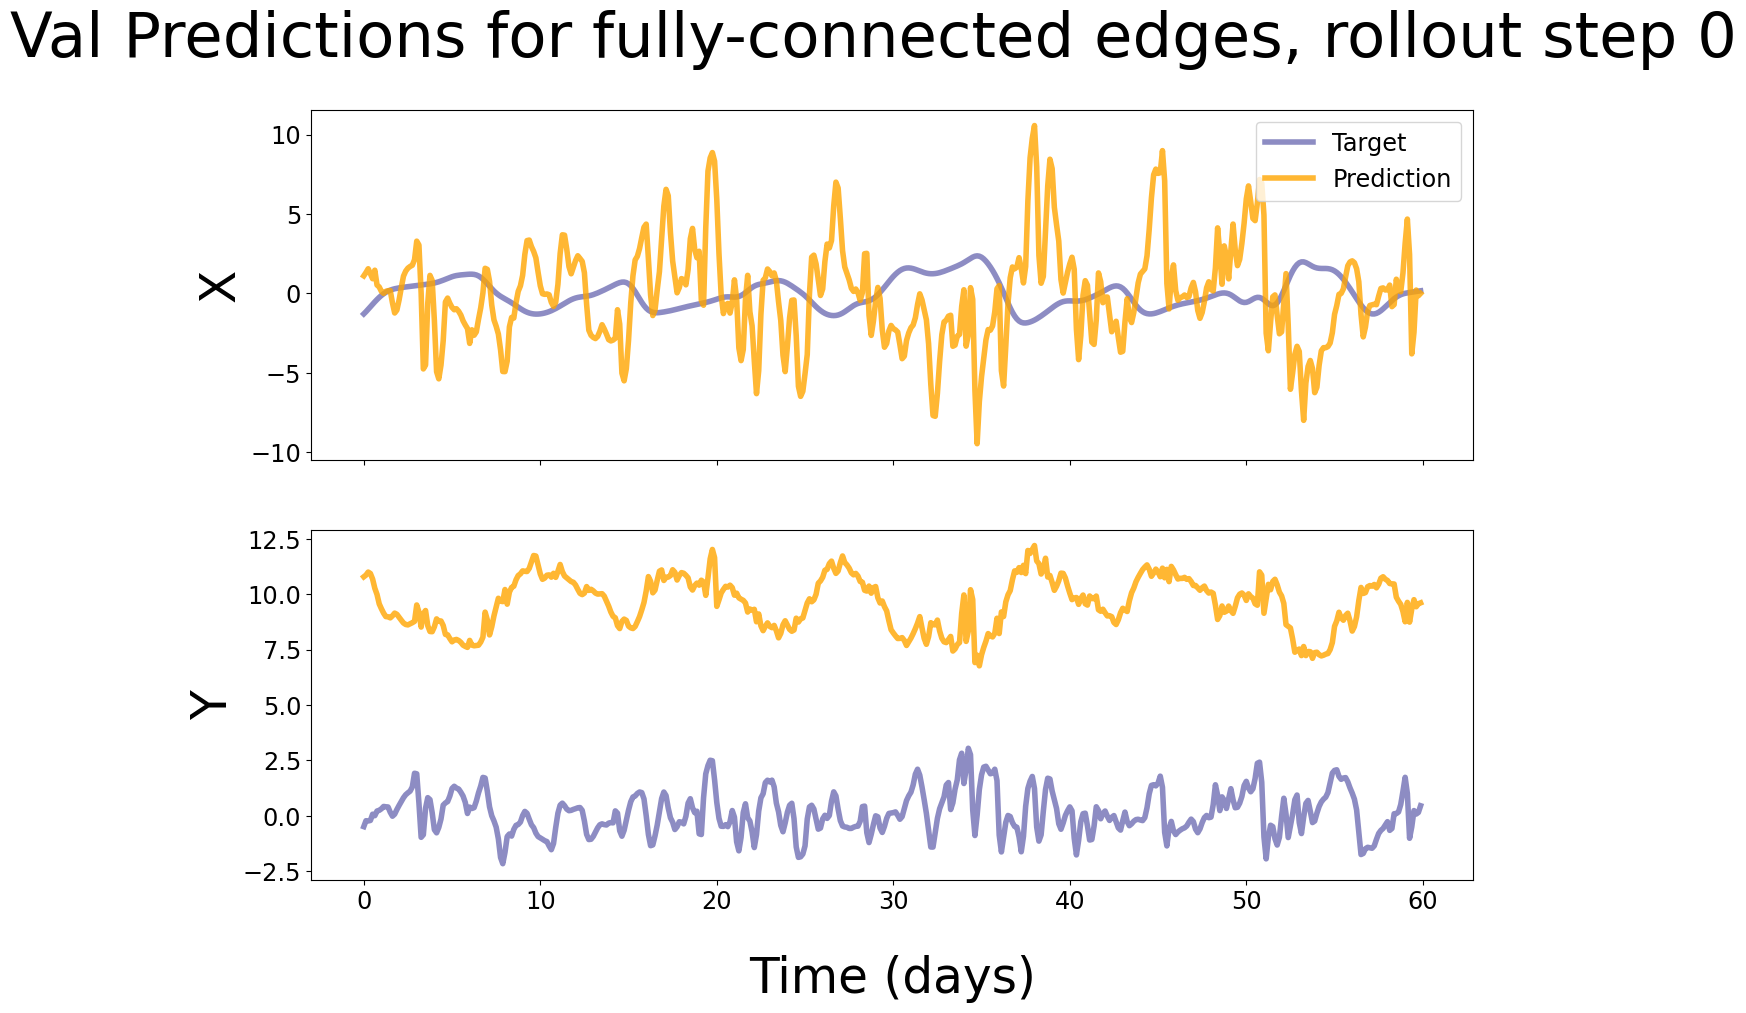

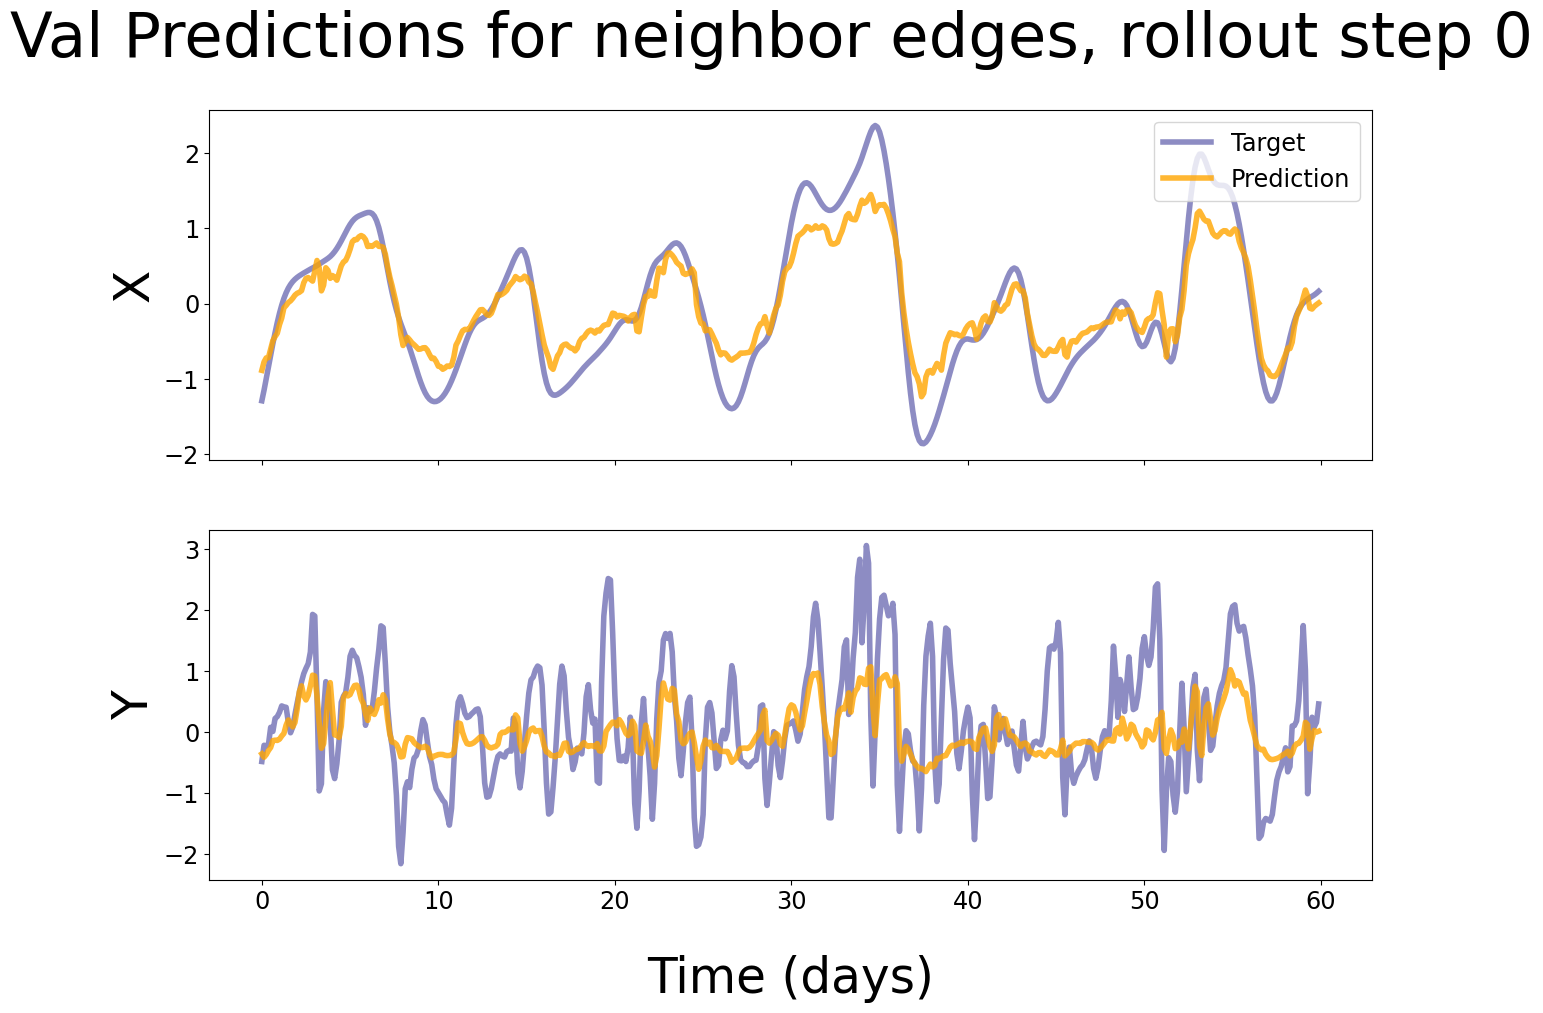

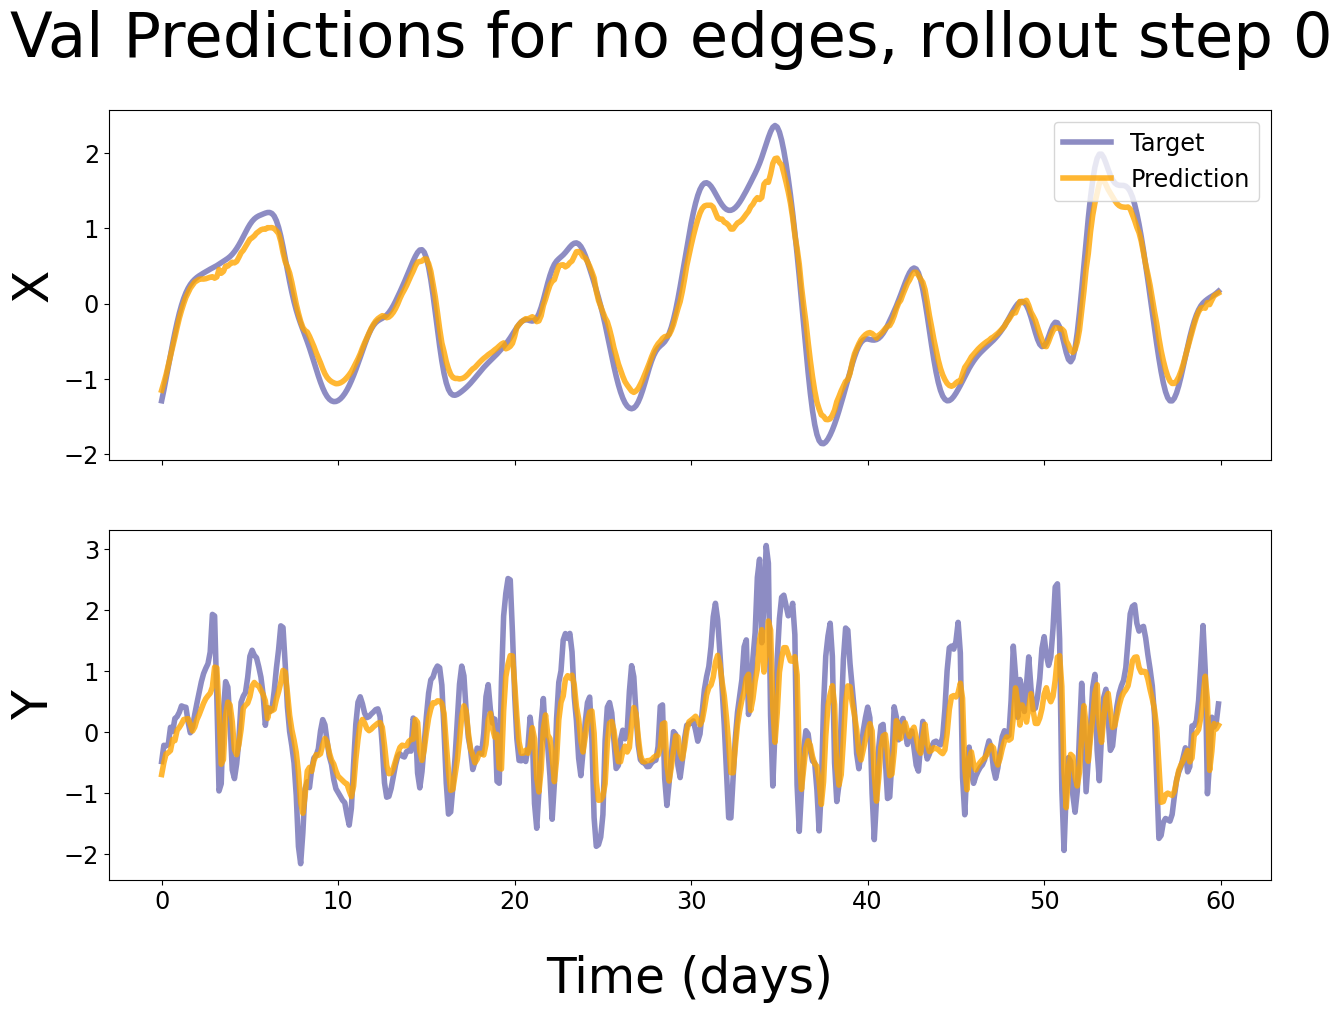

In [65]:
config_type = ["fully-connected", "neighbor", "no"]
for i in range(3):
    plot_predictions(
    config=configs[i],
    workdir=workdirs[i], # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    datasets=all_datasets[i],
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    plot_days=60,
    title=f"Val Predictions for {config_type[i]} edges, rollout step 0")

this is so weird. going to plot what the none graph looks like to see if i'm mega fumbling

In [66]:
# from utils.jraph_vis import draw_jraph_graph_structure

# sample_graph = all_datasets[2]['train']['inputs'][0][0]
# draw_jraph_graph_structure(sample_graph)


In [67]:
def plot_loss_over_epoch(all_epoch_losses, num_epochs):
    filtered_epoch_losses = [epoch_losses[:num_epochs] for epoch_losses in all_epoch_losses]
    epochs = jnp.arange(num_epochs)
    connection_types = ["fully-connected edges", "neighbor-connected edges", "no edges"]
    colors = ["red", "blue", "green"]
    for i in range(len(filtered_epoch_losses)):
        plt.plot(epochs, filtered_epoch_losses[i], alpha=0.6, label=connection_types[i], c=colors[i], marker='o')
    plt.yscale('log')
    plt.ylabel("Epoch Val Loss (log scale)")
    plt.xlabel("Epoch Number")
    plt.title("Epoch Val Losses for Fully-, Neighbor-, and Not-Connected Edges")
    plt.legend(fontsize='large')
    plt.show()

In [75]:
for i in range(3):
    print(all_epoch_losses[i])

[Array(988.36523, dtype=float32)]
[Array(1.1650217, dtype=float32)]
[Array(0.7884171, dtype=float32)]


In [69]:
# plot_loss_over_epoch(all_epoch_losses, 25)

lets see how bad each prediction is at the very beginning (ckpt 1)

In [70]:
def load_model_with_checkpoint(config, workdir, ckpt_path, datasets):
    # Create and initialize the network.
    logging.info('Initializing network.')
    rng = jax.random.key(0)
    rng, init_rng = jax.random.split(rng)
    sample_input_window = datasets["train"]["inputs"][0]
    init_net = create_model(config, deterministic=True)
    params = jax.jit(init_net.init)(init_rng, sample_input_window)
    parameter_overview.log_parameter_overview(params) # logs to logging.info

    # Create the optimizer.
    tx = create_optimizer(config)

    # Create the training state.
    net = create_model(config, deterministic=True) # deterministic because we are doing evaluation, we don't want dropout (that's only for training)
    state = train_state.TrainState.create(
        apply_fn=net.apply, params=params, tx=tx
    )

    # Set up checkpointing of the model.
    # The input pipeline cannot be checkpointed in its current form,
    # due to the use of stateful operations.
    checkpoint_dir = os.path.join(workdir, 'checkpoints')
    ckpt = checkpoint.Checkpoint(checkpoint_dir, 
                                 max_to_keep=config.max_checkpts_to_keep)
    state = ckpt.restore(state=state, checkpoint=ckpt_path)

    return state

lets load each model at their first checkpoint to see the initial predictions

In [71]:
# ckpt_num = 1
# ckpt_path0 = os.path.join(workdirs[0],
#                                      f"checkpoints/ckpt-{ckpt_num}")

# state0 = load_model_with_checkpoint(configs[0], 
#                                                workdirs[0], 
#                                                ckpt_path0,
#                                                all_datasets[0])

In [72]:
# ckpt_num = 1
# ckpt_path1 = os.path.join(workdirs[1],
#                                      f"checkpoints/ckpt-{ckpt_num}")

# state1 = load_model_with_checkpoint(configs[1], 
#                                                workdirs[1], 
#                                                ckpt_path1,
#                                                all_datasets[1])

In [73]:
# ckpt_num = 1
# ckpt_path2 = os.path.join(workdirs[2],
#                                      f"checkpoints/ckpt-{ckpt_num}")

# state2 = load_model_with_checkpoint(configs[2], 
#                                                workdirs[2], 
#                                                ckpt_path2,
#                                                all_datasets[2])